In [1]:
import eventDrivenSimulation as eds
import simulation as sm
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import showPaper as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [2]:
CONFIG = {}

CONFIG['LAT'] = 51.34053598409240
CONFIG['LON'] = 12.381419774766130
CONFIG['RADIUS'] = 500
CONFIG['NUM_UES'] = 100
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [4]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']

eds.plot_map(CONFIG,cell_data)

KeyError: 'ue_data'

In [4]:
df_cell = pd.DataFrame(cell_data)

#### import data

In [5]:
df=pd.read_csv('ue_data_pandas')

In [6]:
sectors=df_cell['pci'].unique()

In [7]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [8]:
max_prb=50 #number of prbs defined by the system bandwidth
ue_nr=15 #number of ues per pci
metric=[1,1] #defines the exponents of the metric (standard metric is pf ->[1,1])

#### Sort out PCIs that have less than ue_nr users -> edge of the Scenario

In [9]:
np.unique(df['TP1'])

array([132, 133, 134, 318, 319, 320, 774, 775, 776], dtype=int64)

In [10]:
#check if the number of users (positions) for the serving pci is >10
df_filter=df.groupby('TP1')
count=0
for i in df['TP1'].unique():
    k=df_filter.get_group(i)
    if(len(k)<ue_nr):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['TP1']!=i]
    count+=1

#### Define a cluster

In [11]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [132 318 774 319 776 320 134 133 775]


In [12]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

if following code says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [13]:
index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packet that arrives from a user [Bit]
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

# select only ue_nr of users from given index 
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

#### Test Different clusters

In [14]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [132 318 774 319 776 320 134 133 775]


In [15]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

#### Run simulation

In [16]:
ue_noCoMP, ue_comp, ue_all,index= sm.run_simulation('deterministic',df,[133,775],4,ue_nr,6,max_prb,'calculate',metric)

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:240: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:270: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


In [17]:
m=0
for i in ue_all:
    m+=i.mR2/i.mR
print(m/len(ue_all))

1.0649910061378387


#### Analyse clusters

In [18]:
Cluster=[[319,775],[320,133],[319,775,320,133],[319,775,320,133,774,318,134,776]]

In [19]:
X={}
cluster_nr=0
for cluster in Cluster:
    ue_noCoMP, ue_comp, ue_all,index= sm.run_simulation('deterministic',df,cluster,4,ue_nr,6,max_prb,'calculate',metric)
    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    X[cluster_nr]=x
    cluster_nr+=1

In [20]:
xxx=np.append(np.array(list(X[0])),np.array((list(X[1]))))

size=2
10% Quantil: -32.4516840196426
90% Quantil: 87.13540718454753
50% Quantil (Median): -7.010903597652051
size=4
10% Quantil: -33.585685979496446
90% Quantil: 107.7458305678278
50% Quantil (Median): -5.76899042431378
size=9
10% Quantil: -39.01381839354202
90% Quantil: 125.24576163818399
50% Quantil (Median): 6.5997919096574496


<Figure size 600x600 with 0 Axes>

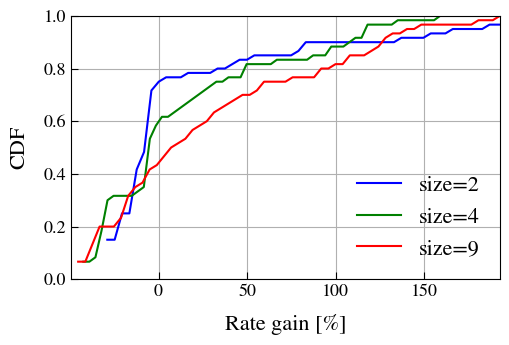

In [21]:
sh.cdf_3(xxx,'size=2','blue',X[2],'size=4','green',X[3][0:60],'size=9','red','',min(x),max(x),'Rate gain [%]',60)

C=2
10% Quantil: -32.4516840196426
90% Quantil: 87.13540718454753
50% Quantil (Median): -7.010903597652051
C=4
10% Quantil: -33.585685979496446
90% Quantil: 107.7458305678278
50% Quantil (Median): -5.76899042431378


<Figure size 600x600 with 0 Axes>

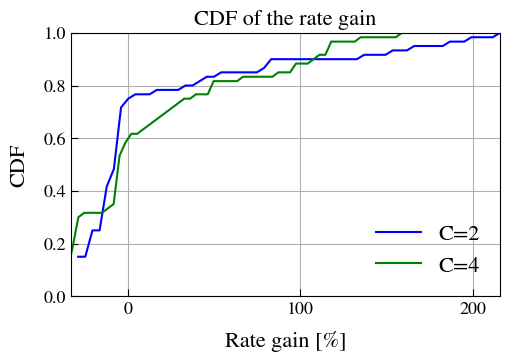

In [22]:
sh.cdf_2(xxx,'C=2','blue',X[2],'C=4','green','CDF of the rate gain',min(xxx),max(xxx),'Rate gain [%]',60)

In [23]:
print('Av. gain for C=2 ' +str(round(np.mean(xxx),3))+'%')
print('Av. gain for C=4 ' +str(round(np.mean(X[2]),3))+'%') 
print('Av. gain for C=9 ' +str(round(np.mean(X[3][0:60]),3))+'%')

Av. gain for C=2 12.86%
Av. gain for C=4 12.809%
Av. gain for C=9 27.114%


In [24]:
lat=np.array([])
lon=np.array([])
for i in ue_all:
    lat=np.append(lat,i.x)
    lon=np.append(lon,i.y)
df_res['latitude']=lat
df_res['longitude']=lon

In [25]:
#df['latitude']=df['lat']
#df['longitude']=df['lon']
#df_r=df[df['SINR-CoMP [dB]']-df['SINR [dB]']>6]
#df_r2=df[df['SINR-CoMP [dB]']-df['SINR [dB]']<6]

In [26]:
df_cluster=df_res[0:60]
df_r=df_cluster[df_cluster['mR gain']>1]
df_r2=df_cluster[df_cluster['mR gain']<1]

df_c2=df_cluster
df_c2['mR gain']=xxx
df_high=df_c2[df_c2['mR gain']>1]
df_low=df_c2[df_c2['mR gain']<1]

<ipython-input-26-0686b2aac1f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c2['mR gain']=xxx


In [27]:
sm.plot_map_cluster(CONFIG,cell_data, df_high,df_low)

In [28]:
df_c2=df_cluster
df_c2['mR gain']=X[2]
df_high=df_c2[df_c2['mR gain']>1]
df_low=df_c2[df_c2['mR gain']<1]

<ipython-input-28-cd5560f34c7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c2['mR gain']=X[2]


In [29]:
sm.plot_map_cluster(CONFIG,cell_data, df_high,df_low)

In [30]:
df_cluster=df_res[0:60]
df_high=df_cluster[df_cluster['mR gain']>1]
df_low=df_cluster[df_cluster['mR gain']<1]

In [31]:
sm.plot_map_cluster(CONFIG,cell_data, df_high,df_low)

In [ ]:
cluster=[319,775,320,133]
x_res=np.array([])
cluster_nr=0
Index={}
for simulation_number in np.arange(0,100):
    
    ue_noCoMP, ue_comp, ue_all, index= sm.run_simulation('random',df,cluster,4,ue_nr,6,max_prb,'calculate',metric)

    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    x_res=np.append(x_res,np.mean(x))
    Index[cluster_nr]=index
    cluster_nr+=1


random


C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:240: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:270: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


random
random
random


In [ ]:
cluster=[319,775]
x_res2=np.array([])
cluster_nr=0
for simulation_number in np.arange(0,100):
    
    #ue_noCoMP, ue_comp, ue_all, index= sm.run_simulation(Index[simulation_number][0:2,:],df,cluster,4,ue_nr,6,max_prb,metric)
    ue_noCoMP, ue_comp, ue_all, index=sm.run_simulation('deterministic',df,cluster,4,ue_nr,6,max_prb,'calculate',metric)
    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    x_res2=np.append(x_res2,np.mean(x))
    cluster_nr+=1


In [49]:
cluster=[320,133]
x_res3=np.array([])
cluster_nr=0
for simulation_number in np.arange(0,100):
    
    #ue_noCoMP, ue_comp, ue_all, index= sm.run_simulation(Index[simulation_number][2:4,:],df,cluster,4,ue_nr,6,max_prb,metric)
    ue_noCoMP, ue_comp, ue_all, index= sm.run_simulation('deterministic',df,cluster,4,ue_nr,6,max_prb,'calculate',metric)

    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    x_res3=np.append(x_res3,np.mean(x))
    cluster_nr+=1


In [50]:
print('Av. gain for C=2 ' +str(round((np.mean(x_res2)+np.mean(x_res3))/2,3))+'%')
print('Av. gain for C=4 ' +str(round(np.mean(x_res),3))+'%') 

Av. gain for C=2 12.593%
Av. gain for C=4 15.492%
